<a href="https://colab.research.google.com/github/dsercam/TC033/blob/main/TC4033_Activity2a_ID_A01182676.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<font color='darkorange'><b> TC 5033 :: Advanced Machine Learning Methods </b> </font>
### <font color='darkgray'><b> Activity 2a: Implementing a FC for *ASL Dataset* Using PyTorch</b></font></br></br>

***Dante Rodrigo Serna Camarillo A01182676***</br>



<br>


- Objective

    The primary aim of this activity is to transition from using Numpy for network implementation to utilizing PyTorch, a powerful deep learning framework. You will be replicating the work you did for the ASL dataset in Activity 1b, but this time, you'll implement a your multi layer FC model using PyTorch.
    
- Instructions

    Review Previous Work: Begin by reviewing your Numpy-based Fully Connected Network for the ASL dataset from Activity 1b. Note the architecture, hyperparameters, and performance metrics for comparison.

    Introduce PyTorch: If you're new to PyTorch, take some time to familiarize yourself with its basic operations and syntax. You can consult the official documentation or follow online tutorials.

    Prepare the ASL Dataset: As before, download and preprocess the Kaggle ASL dataset.

    Implement the Network: Design your network architecture tailored for the ASL dataset. Pay special attention to PyTorch modules like nn.Linear() and nn.ReLU().

    Train the Model: Implement the training loop, making use of PyTorch's autograd to handle backpropagation. Monitor metrics like loss and accuracy as the model trains.

    Analyze and Document: In Markdown cells, discuss the architecture choices, any differences in performance between the Numpy and PyTorch implementations, and insights gained from using a deep learning framework like PyTorch.

In [42]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO
import os
%matplotlib inline

#PyTorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F

# Solamente para usuarios de Jupyter Themes
#from jupyterthemes import jtplot
#jtplot.style(grid=False)

In [ ]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
#DATA_PATH = '/home/pepe/Documents/github_repos/datasets/asl_data'
#train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
#valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### <font color="darkblue"> **1. Import data set** </font>
>>Data sets were loaded into Google drive and exposed to the public.
</br>
>>Then we use the *requests* method to retrieve the files using the downloads URLs.
>>Will download the files form my drive instead of setting them up in my local environment. The previous cell is not required in this way. Will use the same names for the DF to avoid any issue.
>> Get the streamed data into a String format, then read it as CSV format using *read_csv*, assign them to the two data frames.
</Br>
>>> 1. <font color="darkorange"><b> *train_df* </b></font> contains the data of the training file
>>> 2. <font color="darkorange"><b> *valid_df* </b></font> contains the data of the validation file

In [10]:
url = 'https://drive.google.com/uc?export=download&id=1ttUEqCDuNFIenzrr4kMCHkbvBIy9fHmy'
ASLTrainSet = requests.get(url)

url = 'https://drive.google.com/uc?export=download&id=1mbEOJQKvhw41DpBzBB9PSfPr3IsngfA7'
ASLValidationSet = requests.get(url)

trainingAsText = StringIO(ASLTrainSet.text)
validationAsText = StringIO(ASLValidationSet.text)

train_df = pd.read_csv(trainingAsText)
valid_df = pd.read_csv(validationAsText)

### Always a good idea to explore the data

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Get training label data

### <font color="darkblue"> **Clean Up data frames.** </font>
>>> Extract classification (*labels* column in both dataframes)
>>> After getting the classification, remove the link *label* column on both dataframes. This will only leave pixels information
</br>
>>> **y_train** :: (y) traning vector
</br>
>>> **y_validation** :: (y) validation vector

In [5]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [6]:
print(x_train.shape)
print(y_train.shape)

(27455, 784)
(27455,)


In [7]:
print(x_val.shape, y_val.shape)

(7172, 784) (7172,)


In [8]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    assert x.shape[0] == y.shape[0], 'Number of samples x!= number samples y'
    total_samples = x.shape[0]
    if shuffle:
        idxs = np.arange(x.shape[0])
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        #return x_val, y_val, x_test, y_test
#         return x[:total_samples//2, :], y[:total_samples//2], x[total_samples//2:, :], y[total_samples//2:]
    return x[:int(total_samples*pct), :], y[:int(total_samples*pct)], x[int(total_samples*(pct)):, :], y[int(total_samples*(pct)):]


Divide our validation set in two new sets (at 50%) for a new validation and test set.

In [9]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [11]:
type(y_val)

numpy.ndarray

In [12]:
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(3586, 784) (3586,)
(3586, 784) (3586,)


In [13]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise the data

### <font color="darkblue"> **Normalize data** </font>
>> The same way we did on our last activity, normalization will be applied using mean and std of the training data set.

In [14]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [15]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)


In [16]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

In [17]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

In [18]:
type(x_val)

numpy.ndarray

La imagen muestreada representa un: h


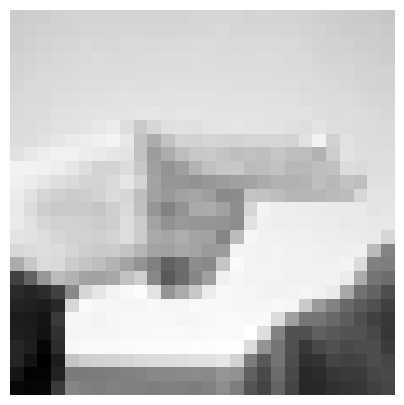

In [19]:
rnd_idx = np.random.randint(len(y_val))
# print(rnd_idx)
# print(y_val[rnd_idx])
print(f'La imagen muestreada representa un: {alphabet[y_val[rnd_idx]]}')
plot_number(x_val[rnd_idx].reshape(28,28))

### The model

$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Create minibatches

In [20]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]

    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

In [21]:
for i, (x, y) in enumerate(create_minibatches(128,x_train, y_train)):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


### Now the PyTorch part

### <font color="darkblue"> **Use pytorch** </font>
>> set up a tensor for each of our sets and y vectors

In [22]:
x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())

This will use the CPU as we are running this on colab

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


### Accuracy

### <font color="darkblue"> **Accuracy method** </font>
>> we will provide a model, a features set, its y vector and the desired size of the mini batches.
>> Method will use the provided model to make its predictions and accuracy will be calcualted against the real classification

In [27]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    cost = 0.
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x, y),1):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            cost += (F.cross_entropy(scores, yi)).item()
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        return cost/mb, float(num_correct)/num_total

### Training Loop

### <font color="darkblue"> **Training method** </font>
>> we will provide a model, the desired optimiser, the number of minibatches and the desired number of epochs (100 by default).
>>

In [25]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    train_cost = 0.
    val_cost = 0.
    for epoch in range(epochs):
        train_correct_num  = 0.
        train_total = 0.
        train_cost_acum = 0
        for mb, (xi, yi) in enumerate(create_minibatches(mb_size, x_train_tensor, y_train_tensor), 1):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            # avoid cummulative gradient
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

            train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
            train_total += scores.size(0)
            #cumulative cost on epoch
            train_cost_acum += cost.item()

        val_cost, val_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        #calculate accuracy on epoch
        train_acc = float(train_correct_num)/train_total
        # calculate cost on epoch
        train_cost = train_cost_acum/mb
        #print accuracy and training cost every 20 epochs, this will avoid a large output, consideirng the larg enumber of epochs
        if epoch%20 == 0:
            print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')


### Model using Sequential

In [28]:
#Instanciar modelo
# hidden1 = 100
hidden = 200
lr = 1e-3
epochs = 100
mb_size = 128
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.878396, val cost: 0.847296, train acc: 0.7226, val acc: 0.751534, lr: 0.004000
Epoch:20, train cost: 0.168783, val cost: 1.857572, train acc: 0.9616, val acc: 0.786670, lr: 0.004000
Epoch:40, train cost: 0.198618, val cost: 2.397053, train acc: 0.9646, val acc: 0.781651, lr: 0.004000
Epoch:60, train cost: 0.203103, val cost: 2.420405, train acc: 0.9638, val acc: 0.796152, lr: 0.004000
Epoch:80, train cost: 0.149200, val cost: 3.051517, train acc: 0.9711, val acc: 0.774958, lr: 0.004000



>> Reached 0.819 accuracy using the test set. This is highet than the ~ 0.78 achieved by our numpy implmentation.

In [29]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)[1]

0.8190184049079755

In [30]:
def predict(x, model):
    x = x.to(device=device, dtype = torch.float32)
    scores = model(x) # mb_size, 10
    _, pred = scores.max(dim=1) #pred shape (mb_size )
    return pred

La imagen muestreada representa un: f


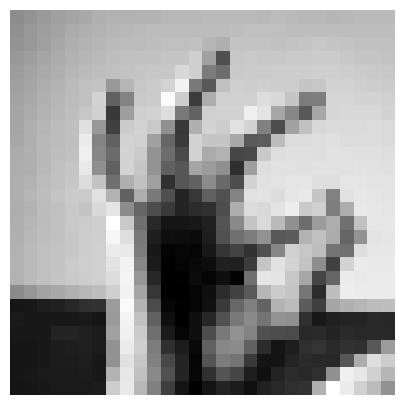

el valor predicho f


In [31]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {alphabet[y_test[rnd_idx]]}')
plot_number(x_test[rnd_idx].reshape(28,28))
pred=predict(x_test_tensor[rnd_idx].reshape(1, -1), model1)
print(f'el valor predicho {alphabet[pred]}')

### <font color="darkblue"> **Playing with  model hyperparameters** </font>
>> Performed some training using different hyperparameters, based on the results I think that increasing the mini-batch size and learning rate (more significant value, even in the same order) hurts the accuracy the most, reducing its accuracy below ~0.8.
</br></br>
>> On the other hand, increasing the hidden layers to 300, reducing the learning rate a bit (1e-25), an increased number of epochs and mainitning the same mini batch size helds the best result.

In [34]:
#Instanciar modelo
# hidden1 = 100
hidden = 300
lr = 1e-25
epochs = 160
mb_size = 128
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.816319, val cost: 0.791442, train acc: 0.7418, val acc: 0.771891, lr: 0.004000
Epoch:20, train cost: 0.278991, val cost: 2.164239, train acc: 0.9590, val acc: 0.796431, lr: 0.004000
Epoch:40, train cost: 0.278496, val cost: 3.201868, train acc: 0.9627, val acc: 0.787228, lr: 0.004000
Epoch:60, train cost: 0.200158, val cost: 4.781935, train acc: 0.9734, val acc: 0.778583, lr: 0.004000
Epoch:80, train cost: 0.157159, val cost: 3.606935, train acc: 0.9760, val acc: 0.795594, lr: 0.004000
Epoch:100, train cost: 0.236820, val cost: 3.694230, train acc: 0.9704, val acc: 0.784161, lr: 0.004000
Epoch:120, train cost: 0.211021, val cost: 4.483946, train acc: 0.9719, val acc: 0.804518, lr: 0.004000
Epoch:140, train cost: 0.215755, val cost: 4.434262, train acc: 0.9717, val acc: 0.788344, lr: 0.004000


In [35]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

(4.191716646325999, 0.8248745119910764)

In [36]:
hidden = 200
lr = 1e-25
epochs = 160
mb_size = 258
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.962449, val cost: 0.762052, train acc: 0.6937, val acc: 0.758226, lr: 0.004000
Epoch:20, train cost: 0.095814, val cost: 1.700981, train acc: 0.9736, val acc: 0.778305, lr: 0.004000
Epoch:40, train cost: 0.127815, val cost: 2.057006, train acc: 0.9711, val acc: 0.785555, lr: 0.004000
Epoch:60, train cost: 0.080822, val cost: 1.982175, train acc: 0.9787, val acc: 0.800613, lr: 0.004000
Epoch:80, train cost: 0.085158, val cost: 2.210984, train acc: 0.9801, val acc: 0.804239, lr: 0.004000
Epoch:100, train cost: 0.075634, val cost: 2.115990, train acc: 0.9807, val acc: 0.798383, lr: 0.004000
Epoch:120, train cost: 0.113531, val cost: 2.435213, train acc: 0.9751, val acc: 0.790853, lr: 0.004000
Epoch:140, train cost: 0.112079, val cost: 2.552875, train acc: 0.9749, val acc: 0.775516, lr: 0.004000


In [37]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

(1.9620583312852042, 0.8087005019520357)

In [38]:
hidden = 300
lr = 1e-20
epochs = 200
mb_size = 64
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.918049, val cost: 1.202405, train acc: 0.7288, val acc: 0.710262, lr: 0.004000
Epoch:20, train cost: 0.260775, val cost: 3.847869, train acc: 0.9598, val acc: 0.790017, lr: 0.004000
Epoch:40, train cost: 0.346229, val cost: 5.501400, train acc: 0.9631, val acc: 0.786113, lr: 0.004000
Epoch:60, train cost: 0.397475, val cost: 5.424882, train acc: 0.9579, val acc: 0.781651, lr: 0.004000
Epoch:80, train cost: 0.365496, val cost: 6.147217, train acc: 0.9620, val acc: 0.783045, lr: 0.004000
Epoch:100, train cost: 0.252292, val cost: 4.932543, train acc: 0.9698, val acc: 0.800892, lr: 0.004000
Epoch:120, train cost: 0.349127, val cost: 5.151676, train acc: 0.9644, val acc: 0.782487, lr: 0.004000
Epoch:140, train cost: 0.393279, val cost: 5.659244, train acc: 0.9603, val acc: 0.799219, lr: 0.004000
Epoch:160, train cost: 0.357001, val cost: 6.783474, train acc: 0.9621, val acc: 0.774400, lr: 0.004000
Epoch:180, train cost: 0.378462, val cost: 6.531421, train acc: 0.9610

In [39]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

(4.764292591496518, 0.7986614612381484)

In [40]:
hidden = 300
lr = 1e-4
epochs = 200
mb_size = 128
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=24))
# optimiser = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=1e-2)
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, 0.1, epochs=epochs, steps_per_epoch=215)

train(model1, optimiser, mb_size, epochs)

Epoch:0, train cost: 0.815985, val cost: 0.942165, train acc: 0.7470, val acc: 0.754322, lr: 0.004000
Epoch:20, train cost: 0.230515, val cost: 2.909075, train acc: 0.9608, val acc: 0.786392, lr: 0.004000
Epoch:40, train cost: 0.217186, val cost: 3.508440, train acc: 0.9688, val acc: 0.785555, lr: 0.004000
Epoch:60, train cost: 0.187211, val cost: 4.519401, train acc: 0.9733, val acc: 0.791969, lr: 0.004000
Epoch:80, train cost: 0.199160, val cost: 3.898890, train acc: 0.9734, val acc: 0.795315, lr: 0.004000
Epoch:100, train cost: 0.232460, val cost: 3.837497, train acc: 0.9697, val acc: 0.786392, lr: 0.004000
Epoch:120, train cost: 0.208058, val cost: 4.420293, train acc: 0.9724, val acc: 0.800335, lr: 0.004000
Epoch:140, train cost: 0.206036, val cost: 4.651578, train acc: 0.9728, val acc: 0.779699, lr: 0.004000
Epoch:160, train cost: 0.171134, val cost: 3.802984, train acc: 0.9765, val acc: 0.800613, lr: 0.004000
Epoch:180, train cost: 0.160813, val cost: 4.996811, train acc: 0.9777

In [41]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

(3.5291224060387445, 0.7947573898494144)